Import packages

In [1257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objs as go

Load data

In [1258]:
train_data = pd.read_csv("data/train.csv")

test_data = pd.read_csv("data/test.csv")

In [1259]:
# Check data
train_data = train_data.fillna(np.nan)
train_data.info()

missing_values_count = train_data.isnull().sum()
print(missing_values_count)

total_cells = np.product(train_data.shape)
total_missing = missing_values_count.sum()

percent_missing = (total_missing/total_cells) * 100
print("Percent of missing values: ", percent_missing)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Per

Summarize data

In [1260]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Preprocessing

In [1261]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1262]:
# Drop Cabin column (687/891) missing values
train_data.drop('Cabin', axis=1)

# Fill embarked nan values of dataset set with 'S', most frequent value
train_data['Embarked'] = train_data['Embarked'].fillna('S')

In [1263]:
from sklearn.preprocessing import OneHotEncoder

# Convert categorical data (Sex and Embarked) one-hot-encoding
object_cols = ['Sex', 'Embarked']
new_cols_name = ['female', 'male', 'C', 'Q', 'S']

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train_data[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(test_data[object_cols]))

OH_cols_train.columns = new_cols_name
OH_cols_valid.columns = new_cols_name

num_X_train = train_data.drop(object_cols, axis=1)
num_X_valid = test_data.drop(object_cols, axis=1)

OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

In [1264]:
OH_X_train.head(10)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,female,male,C,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0.0,1.0,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1.0,0.0,1.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1.0,0.0,0.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1.0,0.0,0.0,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0.0,1.0,0.0,0.0,1.0
5,6,0,3,"Moran, Mr. James",NaN,0,0,330877,8.4583,NaN,0.0,1.0,0.0,1.0,0.0
6,7,0,1,"McCarthy, Mr. Timothy J",54.0,0,0,17463,51.8625,E46,0.0,1.0,0.0,0.0,1.0
7,8,0,3,"Palsson, Master. Gosta Leonard",2.0,3,1,349909,21.0750,NaN,0.0,1.0,0.0,0.0,1.0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.0,0,2,347742,11.1333,NaN,1.0,0.0,0.0,0.0,1.0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",14.0,1,0,237736,30.0708,NaN,1.0,0.0,1.0,0.0,0.0


Feature analysis

Numerical variables

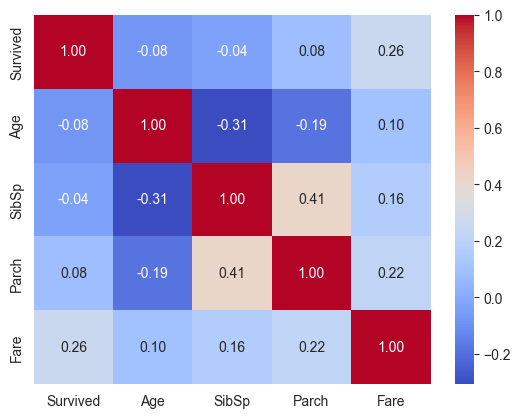

In [1265]:
g = sns.heatmap(train_data[['Survived', 'Age', 'SibSp', 'Parch', 'Fare']].corr(), annot=True, fmt=".2f", cmap="coolwarm")

SibSP

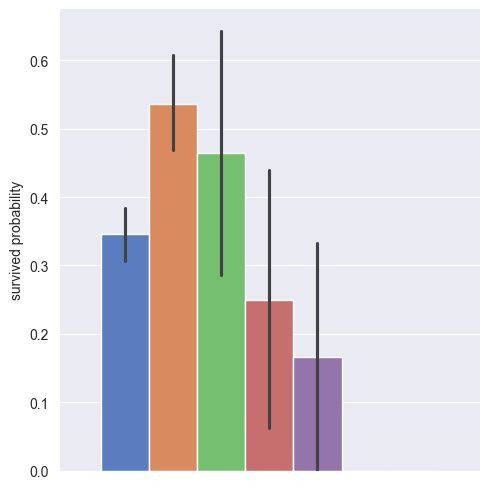

In [1266]:
g = sns.catplot(hue="SibSp", y="Survived", data=train_data, kind="bar", palette="muted", legend=False)
g = g.set_ylabels("survived probability")

Parch

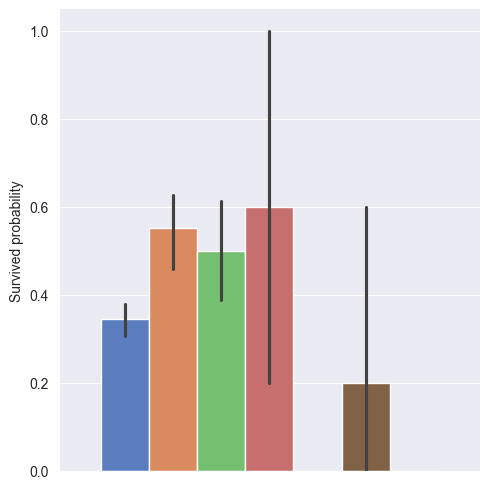

In [1267]:
g = sns.catplot(hue="Parch", y="Survived", data=train_data, kind="bar", palette="muted", legend=False)
g = g.set_ylabels("Survived probability")

Age

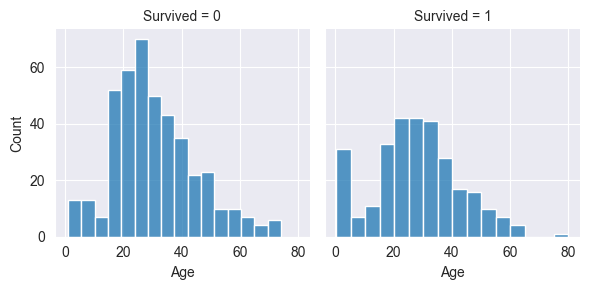

In [1268]:
g = sns.FacetGrid(data=train_data, col="Survived")
g = g.map(sns.histplot  , "Age")

Fare

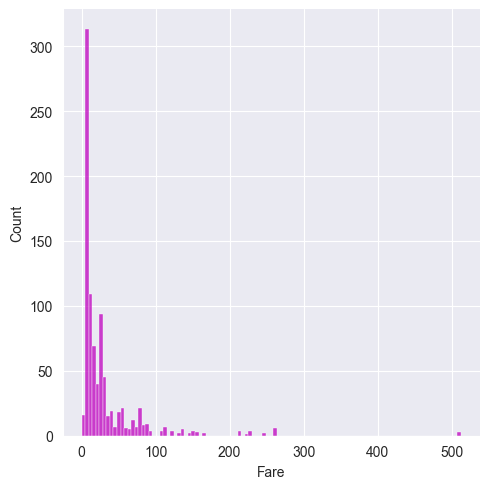

In [1269]:
g = sns.displot(train_data["Fare"], color="m", label="Skewness: %.2f"%(train_data["Fare"].skew()))

In [1270]:
# Apply log to Fare to reduce skewness distribution
train_data["Fare"] = train_data["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

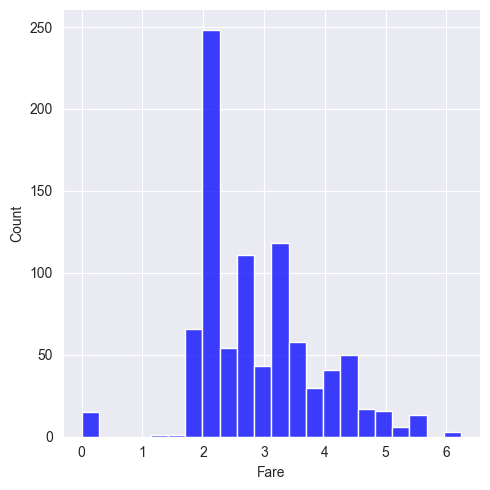

In [1271]:
g = sns.displot(train_data["Fare"], color="b", label="Skewness: %.2f"%(train_data["Fare"].skew()))

Categorical variables

Sex

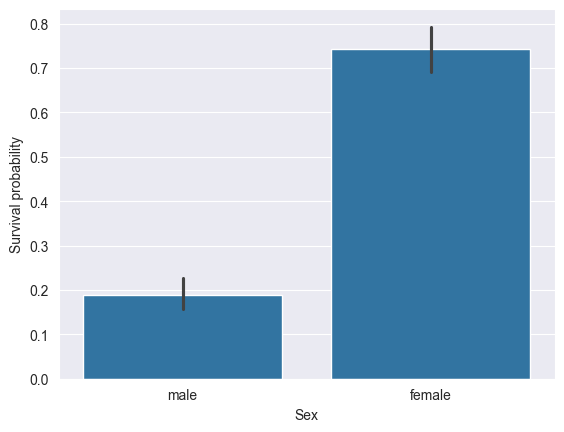

In [1272]:
g = sns.barplot(x="Sex", y="Survived", data=train_data)
g = g.set_ylabel("Survival probability")

In [1273]:
train_data[["Sex", "Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


Pclass

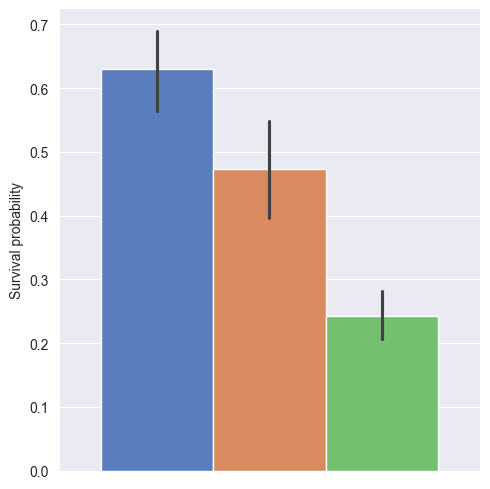

In [1274]:
g = sns.catplot(hue="Pclass", y="Survived", data=train_data, kind="bar", palette="muted", legend=False)
g = g.set_ylabels("Survival probability")

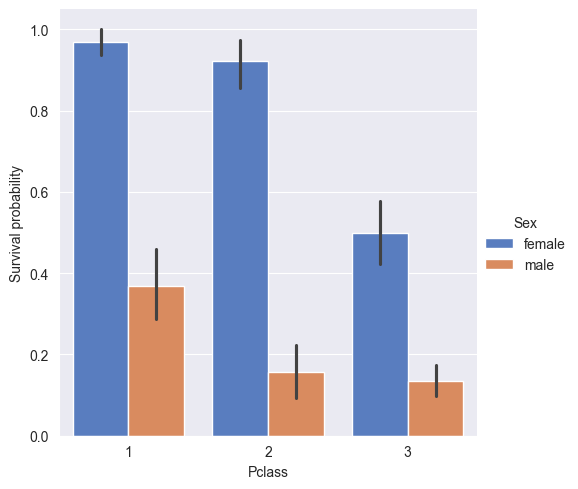

In [1275]:
# Pclass vs Survived by Sex
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train_data, kind="bar", palette="muted")
g = g.set_ylabels("Survival probability")

Embarked

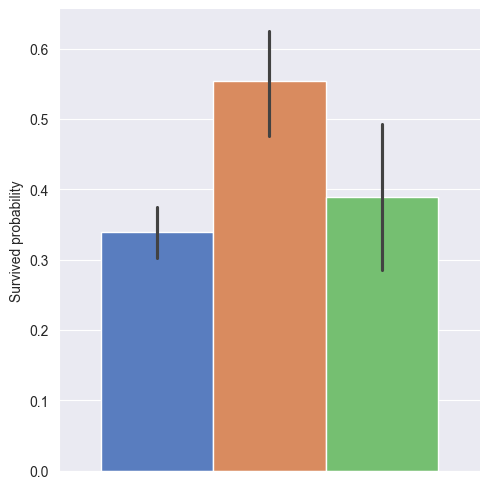

In [1276]:
# Explore Embarked vs Survived
g = sns.catplot(hue="Embarked", y="Survived", data=train_data, kind="bar", palette="muted", legend=False)
g = g.set_ylabels("Survived probability")

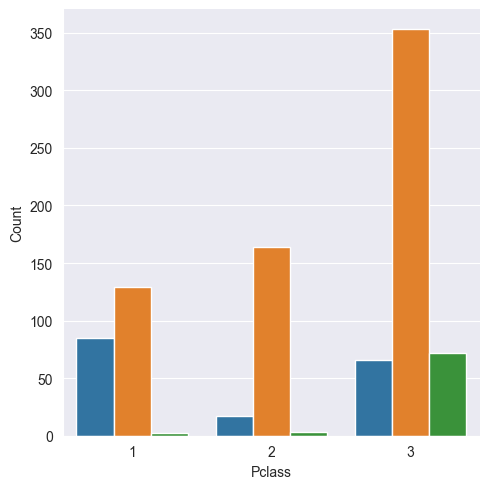

In [1277]:
# Explore Embarked vs Pclass
g = sns.catplot(x="Pclass", hue="Embarked", data=train_data, kind="count", legend=False)
g = g.set_ylabels("Count")

Imports for train model

In [1278]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split ,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Rank different classifiers

In [1279]:
# drop unnecessary cols and select target col
x_train = train_data.loc[:, ~train_data.columns.isin(['Survived', 'Name'])]
y_train = train_data['Survived']

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

Search the best hyperparameters for Random Forest Classifier 

Train model (submit)

In [1282]:
y = train_data["Survived"]
features = ["Pclass", "SibSp", "Parch"]

# X = pd.get_dummies(train_data[features])
# X_test = pd.get_dummies(test_data[features])
X = pd.get_dummies(train_data)
X_test = pd.get_dummies(test_data)

X

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,"Name_Abbing, Mr. Anthony","Name_Abbott, Mr. Rossmore Edward","Name_Abbott, Mrs. Stanton (Rosa Hunt)",...,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,1.981001,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,2,1,1,38.0,1,0,4.266662,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,3,1,3,26.0,0,0,2.070022,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,4,1,1,35.0,1,0,3.972177,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,5,0,3,35.0,0,0,2.085672,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.0,0,0,2.564949,False,False,False,...,False,False,False,False,False,False,False,False,False,True
887,888,1,1,19.0,0,0,3.401197,False,False,False,...,False,False,False,False,False,False,False,False,False,True
888,889,0,3,NaN,1,2,3.154870,False,False,False,...,False,False,False,False,False,False,False,False,False,True
889,890,1,1,26.0,0,0,3.401197,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [1283]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [1284]:
X_test

,PassengerId,Pclass,Age,SibSp,Parch,Fare,"Name_Abbott, Master. Eugene Joseph","Name_Abelseth, Miss. Karen Marie","Name_Abelseth, Mr. Olaus Jorgensen","Name_Abrahamsson, Mr. Abraham August Johannes",...,Cabin_F E46,Cabin_F E57,Cabin_F G63,Cabin_F2,Cabin_F33,Cabin_F4,Cabin_G6,Embarked_C,Embarked_Q,Embarked_S
0,892,3,34.5,0,0,7.8292,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,893,3,47.0,1,0,7.0000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,894,2,62.0,0,0,9.6875,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,895,3,27.0,0,0,8.6625,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,896,3,22.0,1,1,12.2875,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,NaN,0,0,8.0500,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
414,1306,1,39.0,0,0,108.9000,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
415,1307,3,38.5,0,0,7.2500,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
416,1308,3,NaN,0,0,8.0500,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [ ]:
# rf = RandomForestClassifier(max_depth=3, min_samples_leaf=20, n_estimators=10, n_jobs=-1, random_state=0)
# rf.fit(X, y)
# predictions = rf.predict(X_test)
# 
# output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
# output.to_csv('submission.csv', index=False)
# 
# print("Your submission was successfully saved!")

Save prediction to csv file

In [ ]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)

print("Your submission was successfully saved!")

Check output

In [ ]:
results = pd.read_csv('submission.csv')
results.head()